Redoing the portfolio optimization project in multiple methods, using the cookbook for pypfopt!

This example takes two samples from historical prices in order to best perform efficent frontier. One base and one to measure prediction.

We start by getting all the data we can from yfinance

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

tickers = ["EEM", "EFA", "IJR", "SPY", "AGG", "JNK", "SHY"]

ohlc = yf.download(tickers, period="max")
prices = ohlc["Adj Close"]
print(prices.head())
print(prices.tail())

[*********************100%***********************]  7 of 7 completed
            AGG  EEM  EFA  IJR  JNK  SHY        SPY
Date                                               
1993-01-29  NaN  NaN  NaN  NaN  NaN  NaN  25.799770
1993-02-01  NaN  NaN  NaN  NaN  NaN  NaN  25.983273
1993-02-02  NaN  NaN  NaN  NaN  NaN  NaN  26.038315
1993-02-03  NaN  NaN  NaN  NaN  NaN  NaN  26.313566
1993-02-04  NaN  NaN  NaN  NaN  NaN  NaN  26.423655
                   AGG        EEM        EFA         IJR         JNK  \
Date                                                                   
2021-08-11  115.540001  52.320000  81.000000  112.400002  108.830002   
2021-08-12  115.550003  51.860001  80.930000  111.830002  108.970001   
2021-08-13  115.970001  51.730000  81.419998  111.010002  109.160004   
2021-08-16  116.029999  51.259998  81.000000  110.459999  109.190002   
2021-08-17  115.940002  50.320000  80.239998  108.860001  108.980003   

                  SHY         SPY  
Date                      

In [91]:
import pypfopt
from pypfopt import risk_models, expected_returns, plotting
pypfopt.__version__

'1.4.2'

Split our dataframe into two - using one year of data for the future dataframe. Everything else is in past dataframe. We first need to find the best method to project risk.

In [92]:
past_df, future_df = prices.iloc[:-250], prices.iloc[-250:]

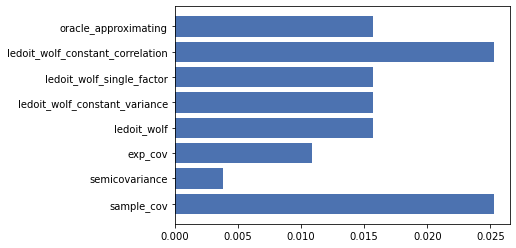

In [93]:
future_variance = np.diag(future_cov)
mean_abs_errors = []

risk_methods = [
    "sample_cov",
    "semicovariance",
    "exp_cov",
    "ledoit_wolf",
    "ledoit_wolf_constant_variance",
    "ledoit_wolf_single_factor",
    "ledoit_wolf_constant_correlation",
    "oracle_approximating",
]

for method in risk_methods:
    S = risk_models.risk_matrix(prices, method=method)
    variance = np.diag(S)
    mean_abs_errors.append(np.sum(np.abs(variance - future_variance)) / len(variance))
    
xrange = range(len(mean_abs_errors))
plt.barh(xrange, mean_abs_errors)
plt.yticks(xrange, risk_methods)
plt.show()

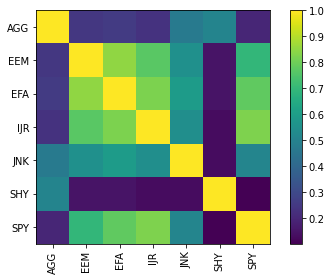

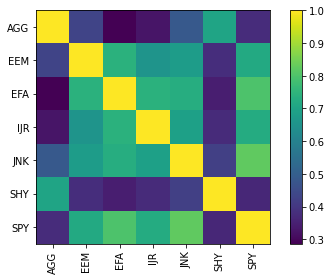

In [94]:
exp_cov = risk_models.semicovariance(past_df)
future_cov = risk_models.semicovariance(future_df)
plotting.plot_covariance(exp_cov, plot_correlation=True)
plotting.plot_covariance(future_cov, plot_correlation=True)
plt.show()
sample_cov = risk_models.semicovariance(prices)

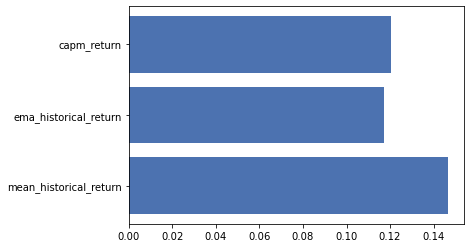

In [95]:
future_rets = expected_returns.mean_historical_return(future_df)
mean_abs_errors = []
return_methods = [
    "mean_historical_return",
    "ema_historical_return",
    "capm_return",
    ]

for method in return_methods:
    mu = expected_returns.return_model(past_df, method=method)
    mean_abs_errors.append(np.sum(np.abs(mu - future_rets)) / len(mu))
    
xrange = range(len(mean_abs_errors))
plt.barh(xrange, mean_abs_errors)
plt.yticks(xrange, return_methods)
plt.show()

capm and ema are fairly close for return estimation. EMA seems to be slightly better. We expect the exponentially-weighted mean average to be closer because of the weight towards more recent returns. 

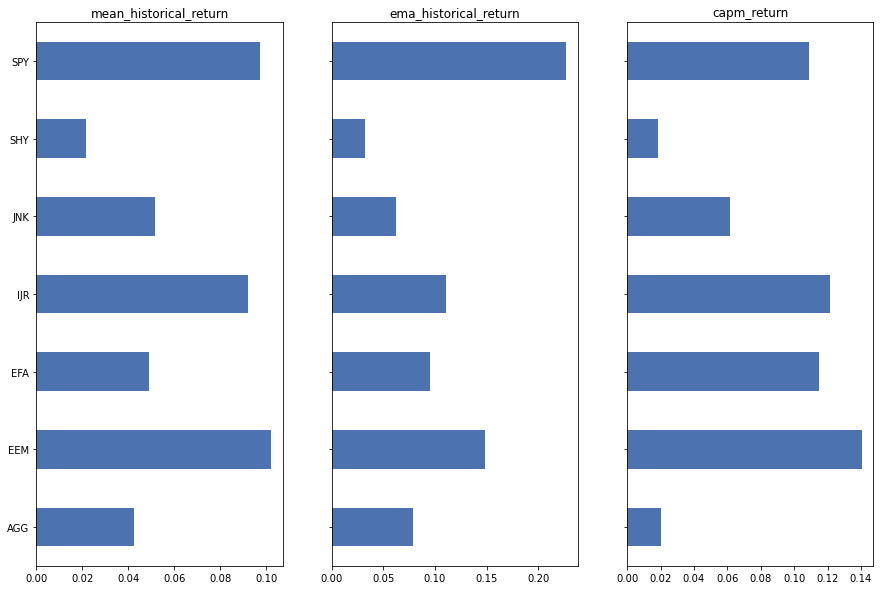

In [96]:
fig, axs = plt.subplots( 1, len(return_methods),sharey=True, figsize=(15,10))

for i, method in enumerate(return_methods):
    mu = expected_returns.return_model(past_df, method=method)
    axs[i].set_title(method)
    mu.plot.barh(ax=axs[i])

In [97]:
mu = expected_returns.capm_return(prices, risk_free_rate=.0126)
print(mu)

AGG    0.012989
EEM    0.147941
EFA    0.120012
IJR    0.128227
JNK    0.058242
SHY    0.010525
SPY    0.114058
Name: mkt, dtype: float64


In [125]:
from pypfopt import EfficientFrontier

ef = EfficientFrontier(mu, sample_cov, weight_bounds=(.01, .333))
ef.min_volatility()
Low_risk_weights = ef.clean_weights()
print(Low_risk_weights)
print(ef.portfolio_performance(risk_free_rate=.0126))
print("\n")
ef.max_sharpe(risk_free_rate=.0126)
med_risk_weights = ef.clean_weights()
print(med_risk_weights)
print(ef.portfolio_performance(risk_free_rate=.0126))
print("\n")
ef = EfficientFrontier(mu, sample_cov, weight_bounds=(.01, .333))
ef.efficient_risk(target_volatility=0.12)
high_risk_weights = ef.clean_weights()
print(high_risk_weights)
print(ef.portfolio_performance(risk_free_rate=.0126))

OrderedDict([('AGG', 0.333), ('EEM', 0.01), ('EFA', 0.01), ('IJR', 0.01), ('JNK', 0.294), ('SHY', 0.333), ('SPY', 0.01)])
(0.030056093790663936, 0.028258202714388503, 0.6177354578101193)


OrderedDict([('AGG', 0.01), ('EEM', 0.2805), ('EFA', 0.08357), ('IJR', 0.15115), ('JNK', 0.333), ('SHY', 0.01), ('SPY', 0.13178)])
(0.10556893487621087, 0.10114589522117363, 0.9191567751999983)


OrderedDict([('AGG', 0.01), ('EEM', 0.333), ('EFA', 0.14869), ('IJR', 0.25561), ('JNK', 0.12621), ('SHY', 0.01), ('SPY', 0.11649)])
(0.12075796527827035, 0.11999999981190947, 0.9013163787316619)


In [126]:
Low_risk_weights_series = pd.Series(Low_risk_weights)
muLR = mu.multiply(Low_risk_weights_series)
LRreturn = muLR.sum()
print(LRreturn)

Med_risk_weights_series = pd.Series(med_risk_weights)
muMR = mu.multiply(Med_risk_weights_series)
MRreturn = muMR.sum()
print(MRreturn)

High_risk_weights_series = pd.Series(high_risk_weights)
muHR = mu.multiply(High_risk_weights_series)
HRreturn = muHR.sum()
print(HRreturn)

0.030056093790663943
0.1055689421855259
0.12075777316123855


In [127]:
LRport_stdev = np.sqrt(Low_risk_weights_series.T.dot(sample_cov).dot(Low_risk_weights_series))
print(LRport_stdev)

MRport_stdev = np.sqrt(Med_risk_weights_series.T.dot(sample_cov).dot(Med_risk_weights_series))
print(MRport_stdev)

HRport_stdev = np.sqrt(High_risk_weights_series.T.dot(sample_cov).dot(High_risk_weights_series))
print(HRport_stdev)

0.028258202714388503
0.10114590317394707
0.119999747811174


In [137]:
conf_level1 = 0.05

from scipy.stats import norm
LRVar = norm.ppf(conf_level1, LRreturn, LRport_stdev)
print(LRVar)

MRVar = norm.ppf(conf_level1, MRreturn, MRport_stdev)
print(MRVar)

HRVar = norm.ppf(conf_level1, HRreturn, HRport_stdev)
print(HRVar)

-0.01642451343522794
-0.060801263501423425
-0.07662424725923307


We use the ppf (or inverse of cdf or cumulative distribution function) in order to get what our return would be at the 5% confidence level. Our possible negative returns in this scenerio are roughly
-1.64%
-6.08%
-7.66%